### Importing torch framework and library with custom YOLO solutions

In [1]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from ultralytics.models.yolo.model import YOLO

### Importing torch sub framework for working with computer vision models

In [2]:
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet34
from torchvision import transforms as T
from torchvision.models.resnet import ResNet

### Importing libs for data manipulation

In [3]:
import numpy as np
from PIL import Image

### Imports for working with environment variables

In [4]:
from dotenv import dotenv_values
from env_enum import ModelEnvKeys, TestEnvKeys

### Imports for type specification and data visualization

In [5]:
from typing import List
import matplotlib.pyplot as plt

### Global variables

In [6]:
random_seed = 42
env_path = "../.env"

### Random seed setup

In [7]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

### Device setup

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")

Device in use: cuda


### Weights reference, data reference

In [9]:
env_config = env_config = dotenv_values(env_path)

In [10]:
resnet_weights_env_key = ModelEnvKeys.RESNET34_WEIGHTS_PATH.value
resnet_weights_path = env_config[resnet_weights_env_key]

yolo_weights_env_key = ModelEnvKeys.YOLO_WEIGHTS_PATH.value
yolo_weights_path = env_config[yolo_weights_env_key]

### Model initialization

In [11]:
def init_resnet34(weights_path:str, num_classes:int=2) -> ResNet:
    
    # Model initialization
    model = resnet34(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    # Loading fine-tuned weights into the model
    state_dict = torch.load(weights_path)
    model.load_state_dict(state_dict)
    
    # Switching model to evaluation mode
    model.eval()
    return model

def init_yolo(weights_path:str) -> YOLO:
    
    # Loading model with fine-tuned weights
    model = YOLO(yolo_weights_path)
    
    return model

In [12]:
resnet_model = init_resnet34(resnet_weights_path)
yolo_model = init_yolo(yolo_weights_path)

### Image processing

In [13]:
class ConvertToRGB:
    def __call__(self, img:Image) -> Image:
        return img.convert("RGB")
    
class AddBatchDim:
    def __call__(self, tensor:torch.Tensor) -> torch.Tensor:
        return tensor.unsqueeze(0)

In [14]:
def resnet_preprocess(img_path:str, device:str="cpu") -> torch.Tensor:
    
    # Reading img using given file path
    img = read_image(img_path)
    
    # Defining img transformations
    preprocess = T.Compose([
        T.ToPILImage(),
        ConvertToRGB(),
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        AddBatchDim()
    ])
    
    # Preprocessing img
    preprocessed_img = preprocess(img)
    
    # Loading preprocessed img on given device
    final_img = preprocessed_img.to(device = device)
    
    return final_img

### Visualization of test images

In [15]:
test_sample1_env_key = TestEnvKeys.MODEL_PIPELINE_SAMPLE1.value
test_sample2_env_key = TestEnvKeys.MODEL_PIPELINE_SAMPLE2.value
test_sample3_env_key = TestEnvKeys.MODEL_PIPELINE_SAMPLE3.value
test_sample4_env_key = TestEnvKeys.MODEL_PIPELINE_SAMPLE4.value
test_sample5_env_key = TestEnvKeys.MODEL_PIPELINE_SAMPLE5.value
test_sample6_env_key = TestEnvKeys.MODEL_PIPELINE_SAMPLE6.value

In [16]:
batch1 = [env_config[test_sample1_env_key], env_config[test_sample2_env_key], env_config[test_sample3_env_key]]
batch2 = [env_config[test_sample4_env_key], env_config[test_sample5_env_key], env_config[test_sample6_env_key]]

In [17]:
preprocess = T.Compose([
        T.ToPILImage(),
        ConvertToRGB(),
        T.Resize(356),
        T.CenterCrop(324),
        T.ToTensor()
])

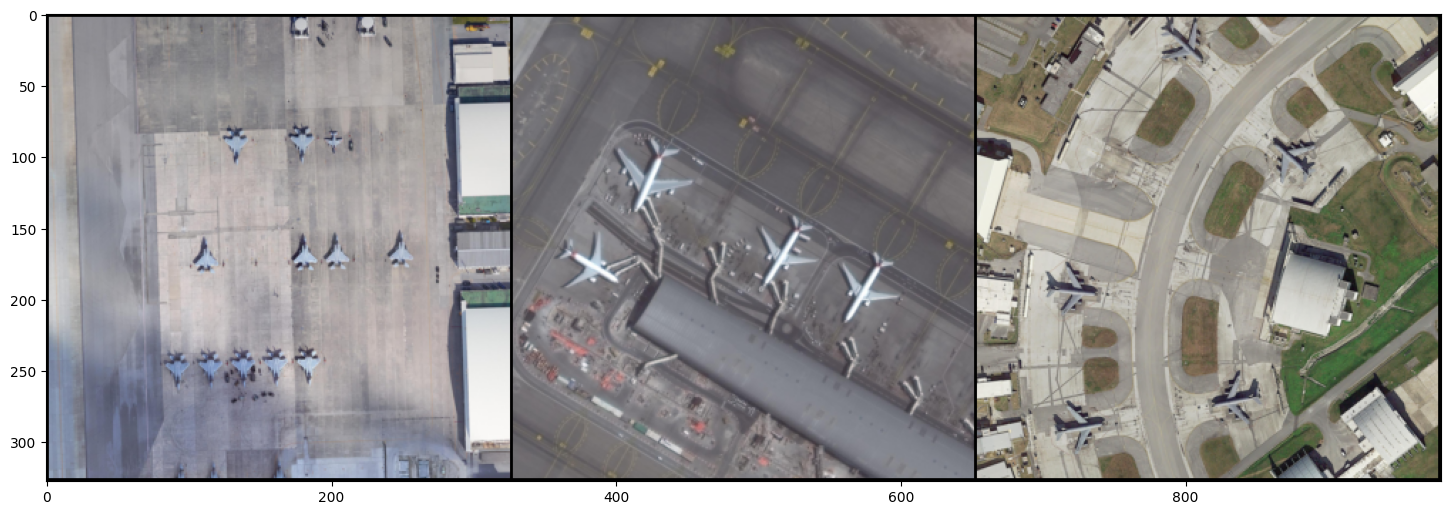

In [18]:
batch = [preprocess(read_image(img_path)) for img_path in batch1]
output = torchvision.utils.make_grid(batch)

plt.figure(figsize=(18, 18))
plt.imshow(output.permute(1, 2, 0))

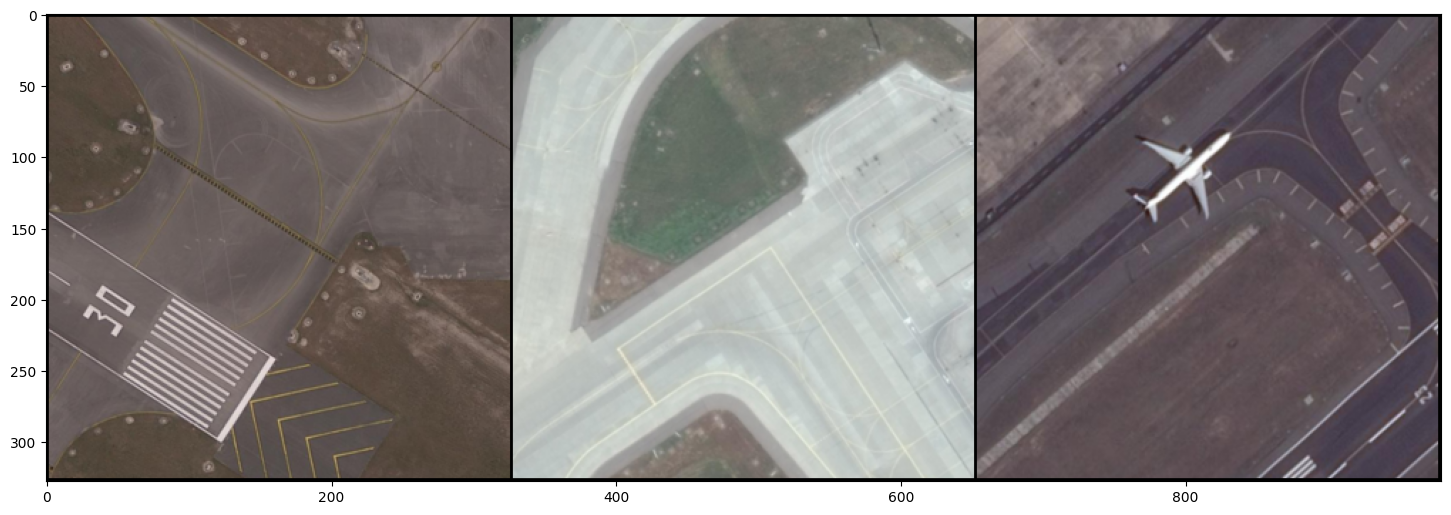

In [19]:
batch = [preprocess(read_image(img_path)) for img_path in batch2]
output = torchvision.utils.make_grid(batch)

plt.figure(figsize=(18, 18))
plt.imshow(output.permute(1, 2, 0))

### Definition of inference functions

In [20]:
@torch.no_grad()
def resnet_infer(model:ResNet, img_path:str, device:str) -> int:
        model = model.to(device=device)
        img = resnet_preprocess(img_path, device)
        output = model(img)
        pred_label = torch.argmax(output, axis=1).item()
        return pred_label

@torch.no_grad()
def yolo_infer(model:YOLO, img_path:str, device:str):
    model = model.to(device=device)
    output = model(img_path)
    return output

def infer(resnet_model:ResNet, yolo_model:YOLO, paths_batch:List[str]) -> List[torch.Tensor]:
    labeled_imgs = list()
    preprocess = T.Compose([
        T.Resize(424),
        T.CenterCrop(400),
        T.ToTensor()
    ])
    
    for i, img_path in enumerate(paths_batch):
        is_plane = resnet_infer(resnet_model, img_path, device)
        if is_plane:
            result = yolo_infer(yolo_model, img_path, device)[0]
            result.save(f"pred_{i}.png")
            img = Image.open(f"pred_{i}.png")
            preprocessed_img = preprocess(img)
            labeled_imgs.append(preprocessed_img)
    
    return labeled_imgs

### Inference

In [21]:
imgs = infer(resnet_model, yolo_model, batch1)        


image 1/1 C:\Program_code\Bachelor\data\resnet_data\raw\122.png: 416x384 15 military planes, 48.1ms
Speed: 2.2ms preprocess, 48.1ms inference, 288.8ms postprocess per image at shape (1, 3, 416, 384)

image 1/1 C:\Program_code\Bachelor\data\resnet_data\raw\110.png: 416x416 4 civilian planes, 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 7.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 C:\Program_code\Bachelor\data\resnet_data\raw\125.png: 416x384 5 civilian planes, 44.9ms
Speed: 7.1ms preprocess, 44.9ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 384)


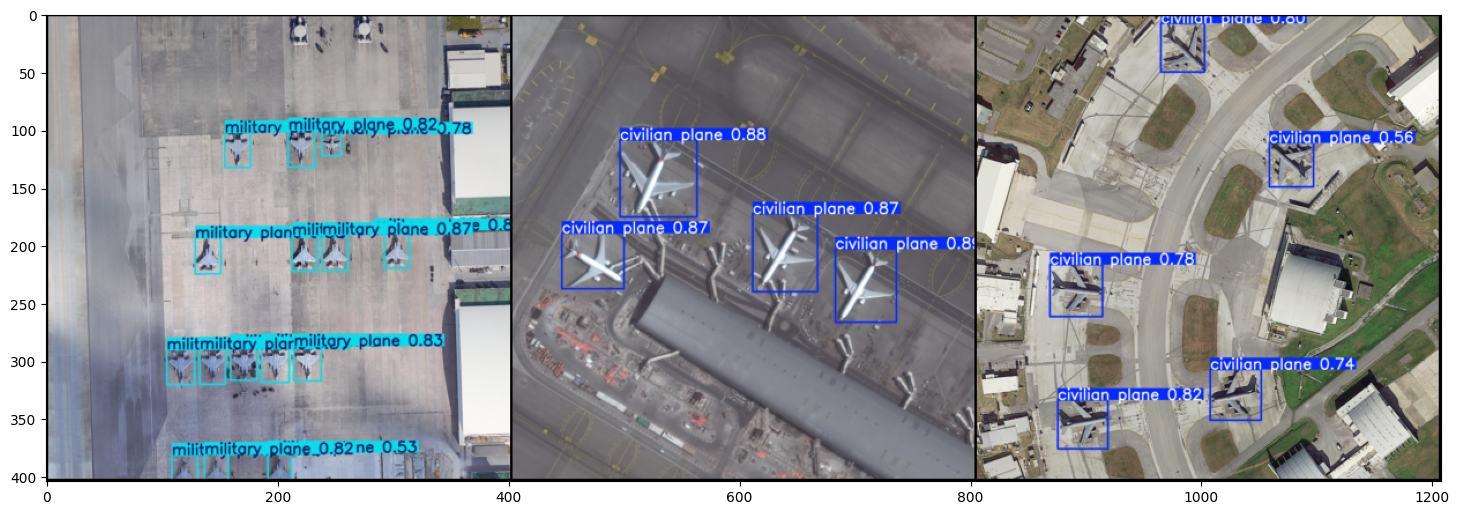

In [22]:
imgs_grid = torchvision.utils.make_grid(imgs)
plt.figure(figsize=(18, 18))
plt.imshow(imgs_grid.permute(1, 2, 0))

In [23]:
imgs = infer(resnet_model, yolo_model, batch2)


image 1/1 C:\Program_code\Bachelor\data\resnet_data\classified\Civilian\plane_608.png: 416x416 1 civilian plane, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 5.9ms postprocess per image at shape (1, 3, 416, 416)


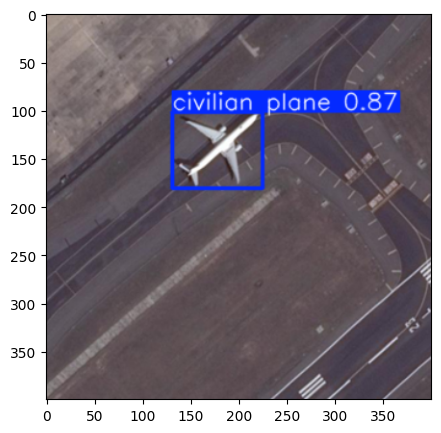

In [24]:
imgs_grid = torchvision.utils.make_grid(imgs)
plt.figure(figsize=(5, 5))
plt.imshow(imgs_grid.permute(1, 2, 0))